# Temperature forecasting - regression with feed-forward, recurrent and bi-directional neural nets

This example uses historical temperature data to predict the temperature 24 hours in advance. I build 3 different models and compare their performance: a standard feed-forward neural network, a recurrent one with Gated Recurrent Units (GRUs), and a Bi-directional recurrent one with GRUs. Unlike in the previous notebooks working with sequence problems in NLP, here the sequence of data points is very important, and therefore the recurrent models are able to show their strength.

## Data preprocessing

In [30]:
import pandas as pd
import numpy as np
datafile = "../data/jena_data/jena_climate_2009_2016.csv"

In [31]:
df = pd.read_csv(datafile)

In [32]:
print("data shape:", df.shape)
df.head()

data shape: (420551, 15)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [33]:
print(df.isnull().values.any())
print(df.isna().values.any())
print(df.isin([0]).values.any())

# Replace inf with nans, and then find nans :)
# df.info()
df.replace([np.inf, -np.inf], np.nan)
# df.info()

df.isnull().values.any()

False
False
True


False

In [34]:
df.drop("Date Time", axis=1, inplace=True)

In [35]:
# Take the temperature column as target data, convert it to numpy array
targets = df['T (degC)'].values
# convert the dataframe into a numpy matrix called `data`
data = df.values

The data contains measurements done each 10 minutes, so there are 144 measurements in a day. We can define the following parameters of the model:
- lookback = 1440 - we'll take data of last 10 days as direct input to the model
- steps = 6 - we won't use all data points since many features don't change much in less then an hour. We'll sample data using steps of 1 hour 
- delay = 144 - how further in the future we'd like to predict (24 hours)

In [36]:
lookback = 1440
steps = 6
delay = 144

In [37]:
train_samples = 200000
val_samples = 100000
# test samples would take the rest of data (or 120551 data rows)

Since the values of different features are spread across different ranges (eg. T is in the tens, and rho in the thousands), we need to normalize and standardize the data - subtract the mean and divide with the standard deviation of data. Here, the mean and st. dev are calculated only on the training set, but applied to the whole data.

In [38]:
mean = data[:train_samples].mean(axis=0)
data -= mean
std = data[:train_samples].std(axis=0)
data /= std

print(std)

# print 2 lines of the processed data
print(data[:2, :])

[ 8.48043388  8.85249908  8.95324185  7.16584991 16.72731652  7.68914559
  4.19808168  4.84034436  2.66564926  4.25206364 42.48884277  1.53666449
  2.33067298 86.61322998]
[[ 0.90014748 -1.93135845 -1.98211036 -1.86280029  1.07285236 -1.30742164
  -1.47375773 -0.79868641 -1.4762674  -1.47815522  2.12375056 -0.72950452
  -0.78067973 -0.27613603]
 [ 0.9060434  -1.97541381 -2.02567    -1.91582958  1.07883061 -1.32042698
  -1.4951961  -0.80075238 -1.49502455 -1.49932141  2.17199852 -0.93124017
  -0.88794488 -0.46317443]]


In [39]:
data.shape

(420551, 14)

Now we can define a Python generator function that will take as input our data and output batches of data, in the suitable format (batch_size, timesteps, num_features) to be inserted in the model. 

In [40]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while True:
        
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            # If we reached the end, start from beginning - to allow us to go through the data many times
            if i + batch_size > max_index:
                i = min_index + lookback
            # make sure you don't go over the length of data
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        # output format: (batch_size, timesteps, num_features)
        samples = np.zeros((len(rows), lookback // step, data.shape[1]))
        targets = np.zeros((len(rows),))
        
        # loop over a batch and create samples and targets
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

The above generator function can now be used to generate the train, validation and test datasets. It would generate samples forever, so in the `fit_generator` method below, we'd need to give values for the number of iterations to use, using the `steps_per_epoch` and `validation_steps` attributes.

There are a few problems I encountered in this part:
- First, the generator code in Cholet's book (see reference) seems to have a problem for the no-shuffling case. I think my fix in the above method is working well.
- Another (bigger issue) is connected to the validation generator which outputs `nan` values after a certain sample is reached. This problem is usually present if `inf` or `nan` values are present in the data, which was not the case for me. People on github suggest to use a different optimizer, like Adam, but this also doesn't help. I assume that the problem is due to some value in the data is equal to 0, so the optimizer at some point makes a division by 0. Therefore I tried normalizing / standardizing the data, not around 0 mean and 1 standard deviation, but in the range [0,1]. 
- A third issue is connected with the selection of the values for `steps_per_epoch` and `validation_steps` in the `fit_generator` method. The right way for this to be done I guess is setting them to a value: `num_samples / batch_size`, so that the whole dataset can be seen. A common mistake is to set these parameters to very large values (eg. the total number of samples in the train / val set) and then an epoch would take too long, so remember to divide by the batch_size.

Another important thing learned from the generator function above is how to shuffle timeseries data in order not to include infromation from the future to predict the past. 

In [41]:
batch_size = 128

train_gen = generator(data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=train_samples,
                     shuffle=True,
                     step=steps,
                     batch_size=batch_size)

val_gen = generator(data,
                    lookback=lookback,
                    delay=delay,
                    min_index=train_samples + 1,
                    max_index=train_samples + val_samples,
                    shuffle=False,
                    step=steps,
                    batch_size=batch_size)

test_gen = generator(data,
                    lookback=lookback,
                    delay=delay,
                    min_index=train_samples + val_samples + 1,
                    max_index=None,
                    shuffle=False,
                    step=steps,
                    batch_size=batch_size)

## A baseline model

The below method `evaluate_baselie` is used to calculate a baseline for the problem. We assume that the temperature 24 hours from the current time would be same as the current one. We calculate the mean absolute error (MAE) using this approach, which is then directly comparable with the output of the model. The MAE for the temperature, using this approach, is around 2.5 celsius degrees, which means this is the average absolute error we'd do with this approach.

Our ML model must try to beat this baseline, which might not always be easy!

In [42]:
def evaluate_baseline():
    batch_maes = []
    
    # Loop the number of times needed to see the whole validation dataset
    val_steps = (train_samples + val_samples - train_samples - lookback - 1) // batch_size + 1
    print("# Validation steps:", val_steps)
    for i in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return np.mean(batch_maes)
    
baseline_error = evaluate_baseline()
print('MAE for baseline approach: %.3f celsius degrees' %  (baseline_error * std[1]))

# Validation steps: 770
MAE for baseline approach: 2.565 celsius degrees


## A standard feed-forward model

This part builds a simple feed-forward neural network with a single hidden layer. The Flatten layer is used to flatten out the data retreived by the above generators, since they generate it for an RNN model in 3 dimensions. After running the model without regularization (which heavily overfitted), I've added some dropout to get better results. Anyway, it doesn't payoff to spend a lot of time in optimizing this first dense network.

In [43]:
# Train steps to take in order to see the entire training set
train_steps = (train_samples - lookback) // batch_size + 1
# Number of steps to see the entire validation set
val_steps = (train_samples + val_samples - train_samples - lookback - 1) // batch_size + 1
# Number of steps to see the entire test set
test_steps = (len(data) - train_samples - val_samples - lookback - 1)  // batch_size + 1

print('train_steps:', train_steps)
print('val_steps:', val_steps)
print('test_steps:', test_steps)

# Build the model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
# We need to flatten the data which is generated to suit a recurrent model
model.add(layers.Flatten(input_shape=(lookback // steps, data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mae')

history = model.fit_generator(train_gen,
                             steps_per_epoch = train_steps,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

train_steps: 1552
val_steps: 770
test_steps: 931
Epoch 1/20
1552/1552 [==============================] - 21s 13ms/step - loss: 0.3852 - val_loss: 0.2900
Epoch 2/20
1552/1552 [==============================] - 19s 13ms/step - loss: 0.2844 - val_loss: 0.2860
Epoch 3/20
1552/1552 [==============================] - 19s 12ms/step - loss: 0.2808 - val_loss: 0.2870
Epoch 4/20
1552/1552 [==============================] - 17s 11ms/step - loss: 0.2767 - val_loss: 0.2958
Epoch 5/20
1552/1552 [==============================] - 17s 11ms/step - loss: 0.2751 - val_loss: 0.2918
Epoch 6/20
1552/1552 [==============================] - 17s 11ms/step - loss: 0.2715 - val_loss: 0.2922
Epoch 7/20
1552/1552 [==============================] - 17s 11ms/step - loss: 0.2679 - val_loss: 0.2902
Epoch 8/20
1552/1552 [==============================] - 18s 11ms/step - loss: 0.2677 - val_loss: 0.2957
Epoch 9/20
1552/1552 [==============================] - 18s 11ms/step - loss: 0.2650 - val_loss: 0.2853
Epoch 10/20
155

In [44]:
def plot_history(history):
    """
    Plots the history of a model training - its loss and accuracy.
    """    
    import matplotlib.pyplot as plt
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

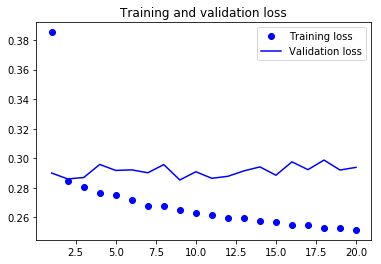

In [45]:
plot_history(history)

In [46]:
# Take the minimum possible MAE reached during training
ff_error = np.min(history.history['val_loss'])
print("Mininmum MAE reached: %.3f." % ff_error)
print('MAE for FF approach: %.3f celsius degrees' %  (ff_error * std[1]))

Mininmum MAE reached: 0.285.
MAE for FF approach: 2.526 celsius degrees


Ok we have beaten the baseline model by a small margin. That means our data has the information needed to perform better than a common sense baseline. In the following parts we'll try to do better with a recurrent network.

## A recurrent model

Next, I can try using a recurrent network with GRU units on the same problem.

In [48]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

num_features = data.shape[1]  # 14 in this case

model = Sequential()
# why isn't there a `timesteps` dimension in the input_shape?
model.add(layers.GRU(32, input_shape=(None, num_features), dropout=0.1, recurrent_dropout=0.3))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, 
                              steps_per_epoch=500, # use less steps than needed
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 55s 110ms/step - loss: 0.3455 - val_loss: 0.2814
Epoch 2/20
500/500 [==============================] - 56s 111ms/step - loss: 0.3078 - val_loss: 0.2757
Epoch 3/20
500/500 [==============================] - 57s 113ms/step - loss: 0.3044 - val_loss: 0.2735
Epoch 4/20
500/500 [==============================] - 57s 115ms/step - loss: 0.2982 - val_loss: 0.2707
Epoch 5/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2939 - val_loss: 0.2678
Epoch 6/20
500/500 [==============================] - 57s 113ms/step - loss: 0.2914 - val_loss: 0.2659
Epoch 7/20
500/500 [==============================] - 57s 115ms/step - loss: 0.2899 - val_loss: 0.2661
Epoch 8/20
500/500 [==============================] - 55s 109ms/step - loss: 0.2883 - val_loss: 0.2629
Epoch 9/20
500/500 [==============================] - 54s 107ms/step - loss: 0.2881 - val_loss: 0.2657
Epoch 10/20
500/500 [==============================] - 53s 106ms/step - l

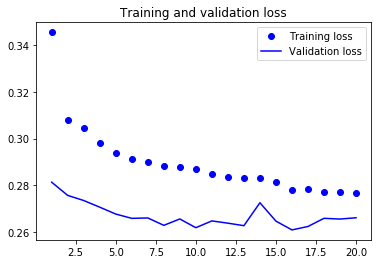

In [50]:
plot_history(history)

In [52]:
# Take the minimum possible MAE reached during training
rnn_error = np.min(history.history['val_loss'])
print("Mininmum MAE reached: %.3f." % rnn_error)
print('MAE for FF approach: %.3f celsius degrees' %  (rnn_error * std[1]))

Mininmum MAE reached: 0.261.
MAE for FF approach: 2.310 celsius degrees


Indeed an RNN network returns better results, even thought we used a very small model with only 32 nodes in the hidden layer. We had an improvement of around 0.2 celsius degrees compared to the feed-forward neural network, and with further optimizations we can achieve more. Anyway, that's enough to show the power of RNN. In the next part I'll use a bi-directional RNN model.

## A bi-directional recurrent model

Usually, the most recent data (coming of a sequence) may hold the most important information. This is how RNNs look at the data too, in chronological order, imputing the most recent data samples at last. But this is not always the case. In many applications, such as in NLP, the start of a sequence can be equally, or more, important than the rest of the sequence. Therefore we might benefit from looking at the data in the two directions. A bi-directional RNN does exactly that: loops through the data in two directions, chronologically, and anti-chronologically, and combines the output of the two. If a one-direction RNN may miss some data representations, these might be picked up when going through data in the other direction. Let's apply this model on the temperature forecasting problem, using the same parameters as the uni-directional RNN above.

In [55]:
num_features = data.shape[1]  # 14 in this case

model_drop = Sequential()
# Why isn't there an activation here?
model_drop.add(layers.Bidirectional(layers.GRU(32, 
                                        dropout=0.1,
                                        recurrent_dropout=0.3,
                                        input_shape=(None, num_features))))
model_drop.add(layers.Dense(1))

model_drop.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                                   steps_per_epoch=500,
                                   epochs=20,
                                   validation_data=val_gen,
                                   validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 54s 108ms/step - loss: 0.2744 - val_loss: 0.2635
Epoch 2/20
500/500 [==============================] - 55s 110ms/step - loss: 0.2743 - val_loss: 0.2627
Epoch 3/20
500/500 [==============================] - 55s 111ms/step - loss: 0.2756 - val_loss: 0.2646
Epoch 4/20
500/500 [==============================] - 55s 110ms/step - loss: 0.2740 - val_loss: 0.2612
Epoch 5/20
500/500 [==============================] - 56s 111ms/step - loss: 0.2733 - val_loss: 0.2623
Epoch 6/20
500/500 [==============================] - 55s 111ms/step - loss: 0.2724 - val_loss: 0.2648
Epoch 7/20
500/500 [==============================] - 56s 111ms/step - loss: 0.2703 - val_loss: 0.2656
Epoch 8/20
500/500 [==============================] - 55s 111ms/step - loss: 0.2703 - val_loss: 0.2673
Epoch 9/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2723 - val_loss: 0.2661
Epoch 10/20
500/500 [==============================] - 55s 110ms/step - l

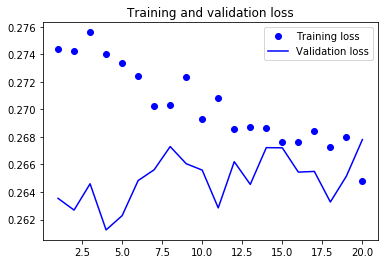

In [57]:
plot_history(history)

In [58]:
# Take the minimum possible MAE reached during training
birnn_error = np.min(history.history['val_loss'])
print("Mininmum MAE reached: %.3f." % birnn_error)
print('MAE for FF approach: %.3f celsius degrees' %  (birnn_error * std[1]))

Mininmum MAE reached: 0.261.
MAE for FF approach: 2.313 celsius degrees


The performance of the bi-directional model is pretty similar to the uni-directional one, at least with using this small model. However, the anti-chronological loop through data samples showed to not be very useful in this case, and that the most recent data is most importna 

This notebook applied three different models to the problem of temperature forecasting. Unlike the NLP problems in previous notebooks, here the sequence of data points adds a valuable information, and therefore the recurrent NN models have visible advantage over the feed-forward one. The three models were not optimized for the task, because that was not in the scope of this notebook. Instead, the focus was to show how the three different models can be built and to get a rough sense of the performance they achieve. All models used a single hidden layer with a small number of nodes in it - 32 only. When overfitting is not the main problem, as in this case, we could always increase the complexity of our models, and of course by adding some regularization. Even more, we could have had stacked multiple recurrent layers on top of each other, and train the models for more epochs. These optimizations will be left for another notebook.

## References
- "Deep Learning with Python" book by Francois Chollet